In [6]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import json
import shutil
import math

#pip install analytic_wfm
from analytic_wfm.peakdetect import *
import cloudpickle
from datetime import datetime
import time

from sklearn.cluster import KMeans, k_means
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

%run "Fonctions.ipynb"
%run "Signal.ipynb"

In [7]:
pd.set_option('display.max_columns', 1000)

In [8]:
# Copie des fichiers .event pour aide export en .txt
copy_event_file("..\Millau")
# copy_event_file("..\Normandie")

In [9]:
# Sélection des meilleurs signaux pour chacun des camions représentés par un fichier .txt
trucks_millau = select_all_best_signal('../Millau/All_event', backup_path="backup/backup_trucks_millau.json")
# trucks_normandie = select_all_best_signal('../Normandie/All_event', backup_path="backup/backup_trucks_normandie.json")

In [10]:
# Récupération des csv contenant les informations de charges
millau = pd.read_csv('../Millau/Fichiers Excel/millau_df_model.csv', index_col=0)
# normandie = pd.read_csv('../Normandie/Fichiers Excel/normandie_df_model.csv', index_col=0)

### Résultats dynamiques

In [11]:
# Trouver les correspondances entre les nswd et les event
trucks_coor_millau_dyn = find_trucks_in_csv(trucks_millau, millau, "backup_trucks_coor_millau_dyn.json")
# trucks_coor_normandie = find_trucks_in_csv(trucks_normandie, normandie, "backup_trucks_coor_normandie.json

In [12]:
# Création des class Signal
trucks_sig_millau_dyn = create_signal_instance(trucks_coor_millau_dyn, filename="class_trucks_millau_dyn.sig")
#trucks_sig_normandie = create_signal_instance(trucks_coor_normandie, filename="class_trucks_normandie.sig")

In [13]:
# Création DataFrame global Millau
all_df_dyn = pd.DataFrame()
for key, value in trucks_sig_millau_dyn.items():
    if (len(value.peaks) > 2) & (len(value.peaks) < 12):
        value = pd.concat([value.to_df(), pd.DataFrame([len(value.peaks)], columns=["longueur"])], axis=1)
        all_df_dyn = pd.concat([all_df_dyn, value], sort=True)
all_df_dyn = all_df_dyn.reset_index(drop=True).sort_index()

Le pic 4.9707 du signal 2017-06-20-12-31-25-246 a eu un problème sur le calcul des fwhms.


In [14]:
# Remplacer 'max' par 1 et 'min' par 2
all_df_dyn.replace(to_replace='max', value=1, inplace=True)
all_df_dyn.replace(to_replace='min', value=2, inplace=True)

In [15]:
all_df_dyn = pd.concat([timestamp_dummies(all_df_dyn['name']), all_df_dyn], axis=1)
all_df_dyn.drop(['name'], axis=1, inplace = True)

In [16]:
#Normalisation des données
all_df_dyn_norm = all_df_dyn.apply(lambda x: (x-np.mean(x))/(1e-10+np.std(x)))

In [17]:
# Complétion NaN
all_df_dyn.fillna(0, inplace=True)

In [18]:
less_df_dyn = all_df_dyn[(all_df_dyn['longueur'] >= 5) &  (all_df_dyn['longueur'] <= 7)]

#### Selection X et Y

In [19]:
loads = list_multiple_var('load_', var_to=8)
y_dyn = all_df_dyn[loads]
X_dyn = all_df_dyn.drop(loads+['Year', 'Month', 'Day', 'Hour', 'Minute', 'Seconde', 'Milliseconde'], axis = 1)

### Résultats statiques

In [20]:
millau_statique = pd.read_csv("../Millau/Fichier statique/millau_statique.csv", sep=";")
millau_statique_date = timestamp_dummies(millau_statique.date)

millau_statique.drop(['date'], axis=1, inplace=True)
millau_statique = pd.concat([millau_statique_date, millau_statique], axis=1)

In [21]:
# Trouver les correspondances entre les nswd et les event
trucks_coor_millau_stat = find_trucks_in_csv(trucks_millau, millau_statique, "backup_trucks_coor_millau_stat.json", statique=True)
# trucks_coor_normandie = find_trucks_in_csv(trucks_normandie, normandie, "backup_trucks_coor_normandie.json")

In [22]:
# Création des class Signal
trucks_sig_millau_stat = create_signal_instance(trucks_coor_millau_stat, filename="class_trucks_millau_stat.sig")
#trucks_sig_normandie = create_signal_instance(trucks_coor_normandie, filename="class_trucks_normandie.sig")

In [23]:
# Création DataFrame global Millau
all_df_stat = pd.DataFrame()
for key, value in trucks_sig_millau_stat.items():
    if (len(value.peaks) > 2) & (len(value.peaks) < 12):
        value = pd.concat([value.to_df(), pd.DataFrame([len(value.peaks)], columns=["longueur"])], axis=1)
        all_df_stat = pd.concat([all_df_stat, value], sort=True)
all_df_stat = all_df_stat.reset_index(drop=True).sort_index()

In [24]:
# Remplacer 'max' par 1
all_df_stat.replace(to_replace='max', value=1, inplace=True)

# Remplacer 'min' par 2
all_df_stat.replace(to_replace='min', value=2, inplace=True)

In [25]:
all_df_stat = pd.concat([timestamp_dummies(all_df_stat['name']), all_df_stat], axis=1)
all_df_stat.drop(['name'], axis=1, inplace = True)

In [26]:
#Normalisation des données
all_df_stat_norm = all_df_stat.apply(lambda x: (x-np.mean(x))/(1e-10+np.std(x)))

In [27]:
# Complétion NaN
all_df_stat.fillna(0, inplace=True)

#### Selection X et Y

In [28]:
loads_s = list_multiple_var('load_s_', var_to=6)
loads = list_multiple_var('load_d_', var_to=6)
y_stat = all_df_stat[loads_s]
X_stat = all_df_stat.drop(loads_s+loads+['Year', 'Month', 'Day', 'Hour', 'Minute', 'Seconde', 'Milliseconde'], axis = 1)

## Prédiction de données

### 1. Stat --> Stat

#### Variables modèle

In [226]:
model_1 = RandomForestRegressor(random_state=42)
param_1 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.5, 0.7],
    "max_depth": [20, 10],
    "min_samples_split" : [5, 7],
    "min_samples_leaf" : [2, 3],
    "oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True]
}
clt_1 = Model(model_1, param_1, GS=True)

#### Prédiction

In [227]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_stat, y_stat, test_size=0.2, random_state=42)
clt_1.fit(X_train_1, y_train_1)

# Vérification modèle
y_train_predict_1 = clt_1.predict(X_train_1)
y_test_predict_1 = clt_1.predict(X_test_1)

clt_1.best_params()
print("\n")
clt_1.best_score(y_train_1, y_test_1, y_train_predict_1, y_test_predict_1)
print("\n")
clt_1.visual(y_test_1, y_test_predict_1)

Best params GS : 
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 20, 'max_features': 0.2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 2000, 'oob_score': True, 'warm_start': True}


Best score GS :  5.964231791015847
Erreur train :  2.3283232578625976
Erreur test :  6.897718300249102




,load_s_1,load_s_2,load_s_3,load_s_4,load_s_5,load_s_6,0,1,2,3,4,5
0,7.0,9.8,9.4,9.5,9.3,0.0,6.072381,7.364294,3.150755,3.621079,3.143449,0.008675
1,7.1,11.8,8.1,8.2,8.4,0.0,6.990179,10.418801,5.452022,5.610449,5.284306,0.261426
2,3.4,4.3,0.0,0.0,0.0,0.0,6.818471,10.658360,5.370987,6.813031,6.758253,0.000000
3,6.9,11.2,4.2,4.3,4.2,0.0,6.236838,7.862117,3.467396,3.902965,3.545914,0.002373
4,7.0,11.4,8.2,8.2,8.3,0.0,6.772707,9.504255,4.940452,5.163478,4.990075,0.418664
5,7.3,11.7,5.7,5.7,5.5,0.0,6.115565,7.606540,3.171235,3.458333,2.789147,0.021747
6,6.3,5.3,4.7,4.6,0.0,0.0,6.631582,9.067113,4.245234,4.909768,4.740516,0.003911
7,5.7,9.2,0.0,3.5,3.5,0.0,6.444997,8.928875,4.507527,4.790095,4.355475,0.013074
8,7.4,11.3,7.8,7.7,8.1,0.0,6.718936,9.549392,4.578000,4.832192,4.693428,0.324646
9,6.7,8.9,5.6,5.1,4.7,0.0,6.636734,9.225201,4.563807,4.831728,4.691241,0.230367


### 2. Dyn --> Dyn

#### Variables modèle

In [228]:
model_2 = RandomForestRegressor(random_state=42)
param_2 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.7, 0.5],
    "max_depth": [100, 150],
    "min_samples_split" : [5, 2],
    "min_samples_leaf" : [2, 5],
    "oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True]
}
clt_2 = Model(model_2, param_2, GS=True)

#### Prédiction

In [229]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_dyn, y_dyn, test_size=0.2, random_state=42)
clt_2.fit(X_train_2, y_train_2)

# Vérification modèle
y_train_predict_2 = clt_2.predict(X_train_2)
y_test_predict_2 = clt_2.predict(X_test_2)

clt_2.best_params()
print("\n")
clt_2.best_score(y_train_2, y_test_2, y_train_predict_2, y_test_predict_2)
print("\n")
clt_2.visual(y_test_2, y_test_predict_2)

Best params GS : 
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2000, 'oob_score': True, 'warm_start': True}


Best score GS :  1.5182941700645152
Erreur train :  0.4313829510361612
Erreur test :  2.0500770513273845




,load_1,load_2,load_3,load_4,load_5,load_6,load_7,load_8,0,1,2,3,4,5,6,7
0,4.884821,6.353804,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.716847,6.066885,0.470599,0.265898,0.189067,0.000000,0.000000,0.0
1,6.488373,11.387688,7.980796,5.811083,6.829135,0.000000,0.0,0.0,5.664929,9.600570,6.401253,5.503908,5.323175,0.085473,0.000000,0.0
2,5.501166,6.425602,5.065922,0.000000,0.000000,0.000000,0.0,0.0,4.843076,5.594719,3.495724,1.749118,0.848692,0.071954,0.073442,0.0
3,4.579229,9.184498,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.947140,7.251282,1.036192,0.760390,0.618401,0.000000,0.000000,0.0
4,5.888429,11.786712,8.640930,5.765050,7.523530,0.000000,0.0,0.0,5.790028,9.897348,7.821797,5.917966,6.517662,0.037771,0.000000,0.0
5,5.996478,8.980039,5.462998,5.351716,4.894919,0.000000,0.0,0.0,5.541126,9.017385,4.979270,4.622658,4.218810,0.015922,0.000000,0.0
6,6.645922,11.510496,6.598859,6.393544,5.942224,0.000000,0.0,0.0,6.109966,10.806917,6.436605,6.015069,5.781001,0.000323,0.000000,0.0
7,5.895794,11.459394,7.822360,7.431516,7.016039,0.000000,0.0,0.0,5.887232,10.444339,7.032110,5.992744,6.174041,0.000000,0.000000,0.0
8,6.627164,12.554976,3.406198,4.837238,3.755813,0.000000,0.0,0.0,5.596495,10.901605,4.625516,4.880095,4.211630,0.130584,0.000000,0.0
9,4.902691,5.195696,2.615790,3.444387,2.941935,0.000000,0.0,0.0,5.155595,5.742818,2.851088,2.672522,2.260560,0.000000,0.000000,0.0


### 3. Dyn --> Stat

#### Variables modèle

In [230]:
model_3 = RandomForestRegressor(random_state=42)
param_3 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.5, 0.7],
    "max_depth": [100, 150],
    "min_samples_split" : [5, 2],
    "min_samples_leaf" : [2, 1],
    "oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True]
}
clt_3 = Model(model_3, param_3, GS=True)

#### Prédiction

In [231]:
clt_3.fit(X_dyn, y_dyn)

# Vérification modèle
y_train_predict_3 = clt_3.predict(X_dyn)
y_test_predict_3 = clt_3.predict(X_stat)

clt_3.best_params()
print("\n")
y_stat_3 = pd.concat([y_stat, pd.DataFrame(np.zeros((len(y_stat),y_test_predict_3.shape[1]-y_stat.shape[1])))], axis=1)
clt_3.best_score(y_dyn, y_stat_3, y_train_predict_3, y_test_predict_3)
print("\n")
clt_3.visual(y_stat, y_test_predict_3)

Best params GS : 
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 2000, 'oob_score': True, 'warm_start': True}


Best score GS :  1.635793367395173
Erreur train :  0.5228278482924638
Erreur test :  5.6308297814563275




,load_s_1,load_s_2,load_s_3,load_s_4,load_s_5,load_s_6,0,1,2,3,4,5,6,7
0,6.9,9.8,6.5,6.5,6.4,0.0,5.852643,9.877394,6.714425,6.120727,4.831808,0.396034,0.000000,0.0
1,7.5,8.6,6.1,6.2,0.0,0.0,5.758800,10.170748,8.321978,7.492819,7.178543,0.131719,0.000000,0.0
2,7.1,11.0,8.5,8.7,8.2,0.0,5.393454,6.841790,3.232890,2.760768,2.549350,0.003919,0.004000,0.0
3,6.7,6.9,2.8,2.7,2.7,0.0,5.506154,8.422800,8.122591,7.308531,6.949695,0.322595,0.000000,0.0
4,5.1,12.7,9.7,10.4,0.0,0.0,5.518549,8.695108,5.386816,5.127947,3.518513,0.140017,0.025441,0.0
5,6.1,3.5,1.4,1.4,1.7,0.0,5.584167,7.082382,3.820378,3.277093,3.027137,0.000000,0.000000,0.0
6,6.0,4.2,2.2,2.5,0.0,0.0,5.584167,7.082382,3.820378,3.277093,3.027137,0.000000,0.000000,0.0
7,4.2,9.1,3.0,3.1,0.0,0.0,5.568047,8.452771,1.527954,0.805148,0.587088,0.000000,0.000000,0.0
8,7.7,9.9,0.0,0.0,0.0,0.0,5.625652,9.025876,5.250086,4.825569,4.579968,0.063654,0.000000,0.0
9,6.7,8.9,5.6,5.1,4.7,0.0,5.728728,9.776940,4.852708,4.700723,3.993725,0.044623,0.000000,0.0


### 4. Dyn - Stat --> Stat

#### Suppression Stat data de Dyn data

In [232]:
time_dyn = timestamp_to_str(all_df_dyn)
time_stat = timestamp_to_str(all_df_stat)

In [233]:
dates_corr = pd.DataFrame()
for index, date in time_stat.iterrows():
    date = datetime.strptime(date['timestamp'], '%Y-%m-%d-%H-%M-%S-%f')
    diff_time = time_dyn['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d-%H-%M-%S-%f')-date).sort_values()
    
    # Test la vérification par rapport à une différence de temps nul et non extravagante pour récupérer l'index
    diff = diff_time[(diff_time > (datetime.min - datetime.min)) & (diff_time < (datetime(1,1,1,0,10,0,0) - datetime.min))]
    
    if not diff.empty:
        # Récupération de la row associé et création du couple key value du dict final
        dates_corr = dates_corr.append(pd.Series(diff.index[0]), ignore_index=True).astype(int)

In [234]:
all_df_without_stat = all_df_dyn.drop(dates_corr[0].tolist(), errors='ignore').reset_index(drop=True)

In [235]:
loads = list_multiple_var('load_', var_to=8)
y_dyn_without_stat = all_df_without_stat[loads]
X_dyn_without_stat = all_df_without_stat.drop(loads+['Year', 'Month', 'Day', 'Hour', 'Minute', 'Seconde', 'Milliseconde', 'longueur'], axis = 1)

#### Variables modèle

In [236]:
model_4 = RandomForestRegressor(random_state=42)
param_4 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.5, 0.7],
    "max_depth": [100, 150],
    "min_samples_split" : [5, 2],
    "min_samples_leaf" : [2, 1],
    "oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True]
}
clt_4 = Model(model_4, param_4, GS=True)

#### Prédiction

In [237]:
clt_4.fit(X_dyn_without_stat, y_dyn_without_stat)

# Vérification modèle
y_train_predict_4 = clt_4.predict(X_dyn_without_stat)
y_test_predict_4 = clt_4.predict(X_stat.drop(['longueur'], axis=1))

clt_4.best_params()
print("\n")
y_stat_4 = pd.concat([y_stat, pd.DataFrame(np.zeros((len(y_stat),y_test_predict_4.shape[1]-y_stat.shape[1])))], axis=1)
clt_4.best_score(y_dyn_without_stat, y_stat_4, y_train_predict_4, y_test_predict_4)
print("\n")
clt_4.visual(y_stat, y_test_predict_4)

Best params GS : 
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2000, 'oob_score': True, 'warm_start': True}


Best score GS :  1.659616482782607
Erreur train :  0.4795461223703729
Erreur test :  5.558164968546073




,load_s_1,load_s_2,load_s_3,load_s_4,load_s_5,load_s_6,0,1,2,3,4,5,6,7
0,6.9,9.8,6.5,6.5,6.4,0.0,5.446889,8.257892,4.919476,4.633870,2.411743,0.349375,0.000000,0.0
1,7.5,8.6,6.1,6.2,0.0,0.0,5.319493,8.967177,6.758558,6.978876,5.749196,0.343095,0.000000,0.0
2,7.1,11.0,8.5,8.7,8.2,0.0,5.110673,5.976843,2.994486,2.781090,2.332305,0.003135,0.003200,0.0
3,6.7,6.9,2.8,2.7,2.7,0.0,5.354593,8.309496,6.196733,5.918397,5.187316,0.262191,0.002400,0.0
4,5.1,12.7,9.7,10.4,0.0,0.0,5.501546,8.466790,4.990969,4.849968,3.054294,0.160789,0.053522,0.0
5,6.1,3.5,1.4,1.4,1.7,0.0,5.597292,6.986301,3.809093,3.271970,3.051466,0.005067,0.004800,0.0
6,6.0,4.2,2.2,2.5,0.0,0.0,5.597292,6.986301,3.809093,3.271970,3.051466,0.005067,0.004800,0.0
7,4.2,9.1,3.0,3.1,0.0,0.0,5.521697,8.235616,1.576021,0.800242,0.574323,0.000000,0.000000,0.0
8,7.7,9.9,0.0,0.0,0.0,0.0,5.616241,8.960748,5.077954,4.689688,4.338078,0.080879,0.000000,0.0
9,6.7,8.9,5.6,5.1,4.7,0.0,5.692138,9.825569,4.906190,4.727668,4.072291,0.063660,0.000000,0.0


### 5. Load Dyn, New Features --> Stat

#### Constituation nouvelle données

In [29]:
X_load_dyn_new_features = pd.concat([all_df_stat[list_multiple_var('load_d_', var_to=6)], X_stat], axis = 1)
y_load_dyn_new_features = y_stat

#### Variables modèle

In [30]:
model_5 = RandomForestRegressor(random_state=42)
param_5 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.5, 0.7],
    "max_depth": [100, 150],
    "min_samples_split" : [5, 2],
    "min_samples_leaf" : [2, 1],
    #"oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True, False]
}
clt_5 = Model(model_5, param_5, GS=True)

#### Prédiction

In [31]:
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_load_dyn_new_features, y_load_dyn_new_features, test_size=0.2, random_state=42)
clt_5.fit(X_train_5, y_train_5)

# Vérification modèle
y_train_predict_5 = clt_5.predict(X_train_5)
y_test_predict_5 = clt_5.predict(X_test_5)

clt_5.best_params()
print("\n")
clt_5.best_score(y_train_5, y_test_5, y_train_predict_5, y_test_predict_5)
print("\n")
clt_5.visual(y_test_5, y_test_predict_5)

Best params GS : 
 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000, 'warm_start': True}


Best score GS :  0.7569657921813733
Erreur train :  3.0035819995070396e-26
Erreur test :  1.2127641107585443




,load_s_1,load_s_2,load_s_3,load_s_4,load_s_5,load_s_6,0,1,2,3,4,5
0,7.0,9.8,9.4,9.5,9.3,0.0,7.02760,11.07415,8.39770,8.62865,8.05790,0.0000
1,7.1,11.8,8.1,8.2,8.4,0.0,7.34225,12.04910,7.29760,7.41760,7.48625,0.0000
2,3.4,4.3,0.0,0.0,0.0,0.0,3.12015,2.93285,0.30980,0.29215,0.17180,0.0000
3,6.9,11.2,4.2,4.3,4.2,0.0,7.09715,10.30960,3.90115,4.07895,3.43515,0.0000
4,7.0,11.4,8.2,8.2,8.3,0.0,7.54075,11.76070,7.84935,8.02625,8.01090,0.0000
5,7.3,11.7,5.7,5.7,5.5,0.0,7.15890,10.76135,5.52570,5.61840,5.59565,0.0000
6,6.3,5.3,4.7,4.6,0.0,0.0,6.26325,5.94650,4.06150,3.95550,1.07870,0.0000
7,5.7,9.2,0.0,3.5,3.5,0.0,6.50830,8.82605,1.02515,3.55770,3.19535,0.1248
8,7.4,11.3,7.8,7.7,8.1,0.0,7.29010,12.14880,7.07960,7.41060,7.47350,0.0064
9,6.7,8.9,5.6,5.1,4.7,0.0,6.99190,9.85410,5.83565,5.99800,5.87710,0.2528


### 6. Load Dyn, pred (Dyn --> Stat), longueur --> Stat

#### Constituation nouvelle données

In [241]:
X_load_dyn_pred_long = pd.concat([all_df_stat[list_multiple_var('load_d_', var_to=6)], pd.DataFrame(y_test_predict_4).iloc[:,0:5], all_df_stat['longueur']], axis = 1)
y_load_dyn_pred_long = all_df_stat[list_multiple_var('load_s_', var_to=6)]

#### Variables modèle

In [242]:
model_6 = RandomForestRegressor(random_state=42)
param_6 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.5, 0.7],
    "max_depth": [100, 150],
    "min_samples_split" : [5, 2],
    "min_samples_leaf" : [2, 1],
    #"oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True, False]
}
clt_6 = Model(model_6, param_6, GS=True)

#### Prédiction

In [243]:
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_load_dyn_pred_long, y_load_dyn_pred_long, test_size=0.2, random_state=42)
clt_6.fit(X_train_6, y_train_6)

# Vérification modèle
y_train_predict_6 = clt_6.predict(X_train_6)
y_test_predict_6 = clt_6.predict(X_test_6)

clt_6.best_params()
print("\n")
clt_6.best_score(y_train_6, y_test_6, y_train_predict_6, y_test_predict_6)
print("\n")
clt_6.visual(y_test_6, y_test_predict_6)

Best params GS : 
 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000, 'warm_start': True}


Best score GS :  0.648463912352936
Erreur train :  3.0035819995070396e-26
Erreur test :  1.2802673008653782




,load_s_1,load_s_2,load_s_3,load_s_4,load_s_5,load_s_6,0,1,2,3,4,5
0,7.0,9.8,9.4,9.5,9.3,0.0,6.97235,11.24700,8.49510,8.66045,7.96185,0.0000
1,7.1,11.8,8.1,8.2,8.4,0.0,7.31770,12.09785,7.29410,7.50915,7.59830,0.0000
2,3.4,4.3,0.0,0.0,0.0,0.0,3.35190,3.10880,0.18885,0.32275,0.15605,0.0000
3,6.9,11.2,4.2,4.3,4.2,0.0,7.15615,11.19045,3.94370,4.00775,3.80390,0.0000
4,7.0,11.4,8.2,8.2,8.3,0.0,7.23705,12.28625,7.20395,8.47925,8.28495,0.0000
5,7.3,11.7,5.7,5.7,5.5,0.0,7.03875,10.95045,5.52970,5.60200,5.63890,0.0000
6,6.3,5.3,4.7,4.6,0.0,0.0,6.16110,5.71795,4.64885,4.54335,0.54920,0.0000
7,5.7,9.2,0.0,3.5,3.5,0.0,6.56970,8.59395,0.81365,3.56870,3.36985,0.0832
8,7.4,11.3,7.8,7.7,8.1,0.0,7.25875,12.43865,6.41970,7.62165,7.71030,0.0000
9,6.7,8.9,5.6,5.1,4.7,0.0,6.94815,9.71990,5.66010,5.79910,5.74245,0.5728


### 7. Clusters (1 modèle/cluster)

#### Prédiction des clusters

In [43]:
# Dynamique
kms_dyn = KMeans(4)
kms_dyn.fit(X_dyn)
clusters_dyn = pd.DataFrame(kms_dyn.predict(X_dyn), columns=['cluster'])

def kms_predict(X_test):
    return kms_dyn.predict(X_test)

    ## Séparation des clusters
clt_dyn = []
for i in range(4):
    clt_dyn.append(clusters_dyn[clusters_dyn["cluster"] == i])
    

# Statique
clusters_stat = pd.DataFrame(kms_predict(X_stat), columns=['cluster'])

    ## Séparation des clusters
clt_stat = []
for i in range(4):
    clt_stat.append(clusters_stat[clusters_stat["cluster"] == i])

#### Affichage graphique

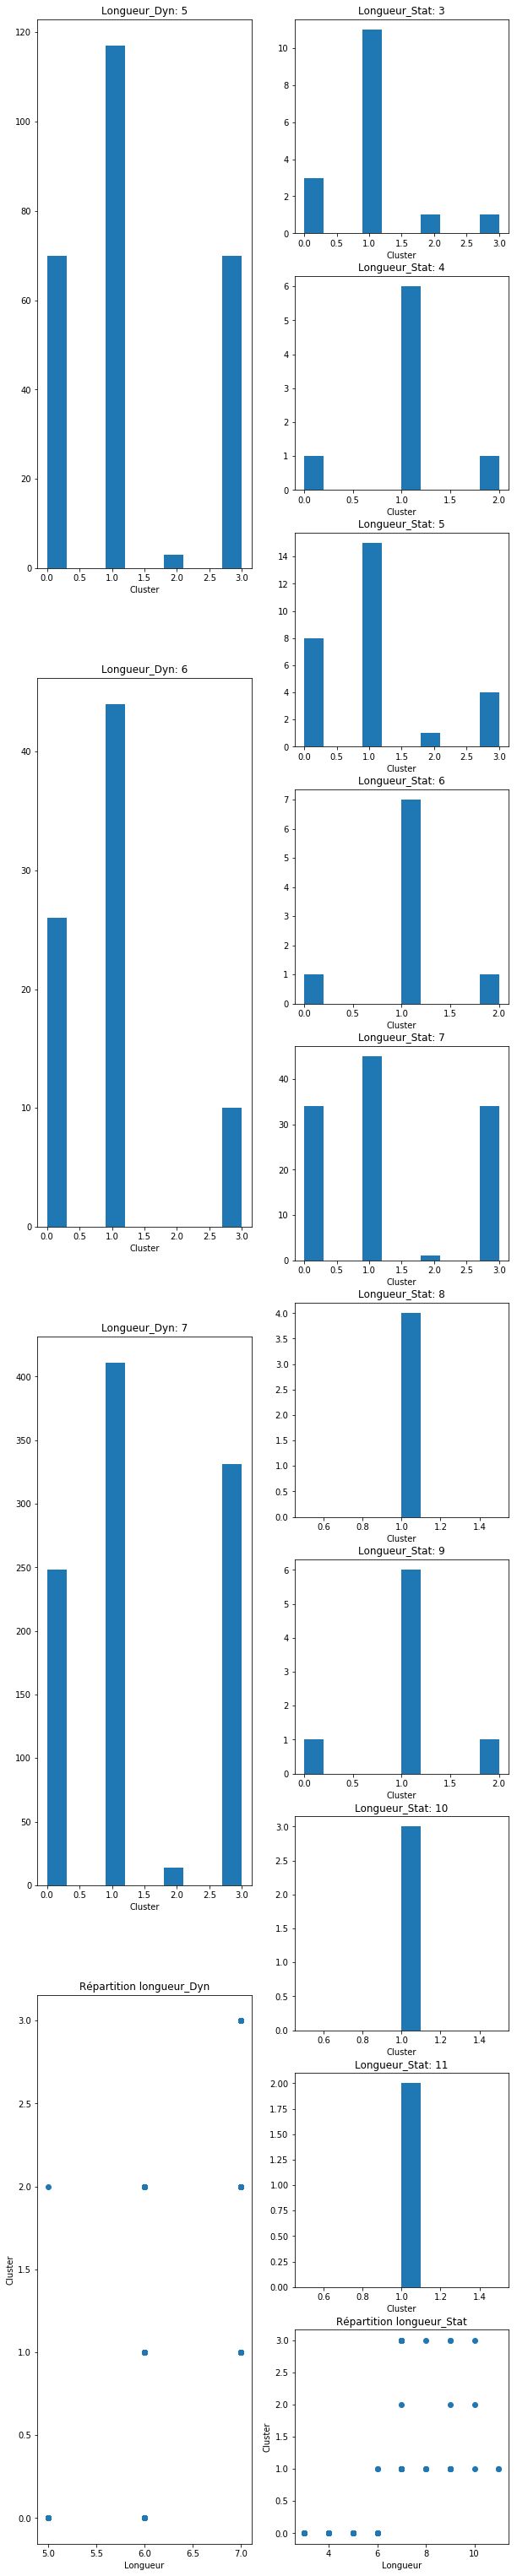

In [284]:
plt.figure(figsize=(10,55))

# Dynamique
len_for = pd.DataFrame(all_df_dyn['longueur']).apply(pd.value_counts).index.sort_values()
i=-1
for k in len_for:
    i+=2
    plt.subplot(len(len_for)+1, 2, i)
    plt.hist(clusters_dyn.reindex(all_df_dyn['longueur'][all_df_dyn['longueur'] == k].reset_index(drop=True).index).T)
    plt.xlabel("Cluster")
    plt.title("Longueur_Dyn: " + str(k))
    
plt.subplot(len(len_for)+1, 2, i+2)
plt.scatter(all_df_dyn['longueur'], clusters_dyn.T)
plt.ylabel("Cluster")
plt.xlabel("Longueur")
plt.title("Répartition longueur_Dyn")

# Statique 
len_for = pd.DataFrame(all_df_stat['longueur']).apply(pd.value_counts).index.sort_values()
i=0
for k in len_for:
    i+=2
    plt.subplot(len(len_for)+1, 2, i)
    plt.hist(clusters_stat.reindex(all_df_stat['longueur'][all_df_stat['longueur'] == k].reset_index(drop=True).index).T)
    plt.xlabel("Cluster")
    plt.title("Longueur_Stat: " + str(k))
    
plt.subplot(len(len_for)+1, 2, i+2)
plt.scatter(all_df_stat['longueur'], clusters_stat.T)
plt.ylabel("Cluster")
plt.xlabel("Longueur")
plt.title("Répartition longueur_Stat")
plt.show()

### Modèle de prédiction

In [257]:
# Modèle 1
model_1_1 = RandomForestRegressor(random_state=42)
param_1_1 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.1, 0.2, 0.3],
    "max_depth": [100, 150],
    "min_samples_split" : [5, 2],
    "min_samples_leaf" : [2, 1],
    #"oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True, False]
}
clt_1 = Model(model_1_1, param_1_1, GS=True)

# Modèle 2
model_1_2 = RandomForestRegressor(random_state=42)
param_1_2 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.5, 0.7],
    "max_depth": [100, 150],
    "min_samples_split" : [15, 10],
    "min_samples_leaf" : [2, 1],
    "oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True]
}
clt_2 = Model(model_1_2, param_1_2, GS=True)

# Modèle 3
model_1_3 = RandomForestRegressor(random_state=42)
param_1_3 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.5, 0.7],
    "max_depth": [100, 150],
    "min_samples_split" : [15, 10],
    "min_samples_leaf" : [2, 1],
    "oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True]
}
clt_3 = Model(model_1_3, param_1_3, GS=True)

# Modèle 4
model_1_4 = RandomForestRegressor(random_state=42)
param_1_4 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.5, 0.7],
    "max_depth": [100, 150],
    "min_samples_split" : [5, 2],
    "min_samples_leaf" : [2, 1],
    "oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True]
}
clt_4 = Model(model_1_4, param_1_4, GS=True)

#### Attribution des modèles aux données de clusters

In [258]:
# Dynamique
clusters_models_dyn = { # key : nbr cluster, value: modèle à utiliser
    0: clt_1,
    1: clt_2,
    2: clt_3,
    3: clt_4
}

# Séparation Train/Test et apprentissage des données
for key, value in clusters_models_dyn.items():
    X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dyn.iloc[clt_dyn[key].index, :], y_dyn.iloc[clt_dyn[key].index, :], test_size=0.2, random_state=42)
    value.fit(X_train_dyn, y_train_dyn)
    
    # Vérification modèle
    y_train_predict_dyn = value.predict(X_train_dyn)
    y_test_predict_dyn = value.predict(X_test_dyn)
    
    print("Dyn. Cluster : " + str(key+1))
    value.best_score(y_train_dyn, y_test_dyn, y_train_predict_dyn, y_test_predict_dyn)
    value.best_params()
    value.visual(y_test_stat, y_test_predict_stat)
    print("\n")

Dyn. Cluster : 1
Best score GS :  1.5232588923167845
Erreur train :  0.37159633124657043
Erreur test :  1.2786698168296202
Best params GS : 
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 2000, 'warm_start': True}


Dyn. Cluster : 2
Best score GS :  2.7229987826017803
Erreur train :  1.3625792363489007
Erreur test :  2.514741166968839
Best params GS : 
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 2000, 'oob_score': True, 'warm_start': True}


Dyn. Cluster : 3
Best score GS :  1.2076715702209104
Erreur train :  0.5511204319872309
Erreur test :  1.6579406042688731
Best params GS : 
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 2000, 'oob_score': True, 'warm_start': True}


Dyn. Cluster : 4
Best score

In [119]:
# Modèle 1
model_2_1 = RandomForestRegressor(random_state=42)
param_2_1 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.5, 0.2],
    "max_depth": [100, 50],
    "min_samples_split" : [5, 10],
    "min_samples_leaf" : [2, 10],
    #"oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True, False]
}
clt_2_1 = Model(model_2_1, param_2_1, GS=True, cv=2)

# Modèle 2
model_2_2 = RandomForestRegressor(random_state=42)
param_2_2 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.5, 0.2],
    "max_depth": [100, 50],
    "min_samples_split" : [5, 10],
    "min_samples_leaf" : [2, 10],
    #"oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True, False]
}
clt_2_2 = Model(model_2_2, param_2_2, GS=True, cv=2)

# Modèle 3
model_2_3 = RandomForestRegressor(random_state=42)
param_2_3 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.9, 0.7],
    "max_depth": [100, 80],
    "min_samples_split" : [3, 2],
    "min_samples_leaf" : [3, 2],
    "oob_score" : [True],
    "warm_start" : [True],
    "bootstrap" : [True]
}
clt_2_3 = Model(model_2_3, param_2_3, GS=True, cv=2)

# Modèle 4
model_2_4 = RandomForestRegressor(random_state=42)
param_2_4 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.5, 0.2],
    "max_depth": [100, 50],
    "min_samples_split" : [5, 10],
    "min_samples_leaf" : [2, 10],
    #"oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True, False]
}
clt_2_4 = Model(model_2_4, param_2_4, GS=True, cv=2)

In [120]:
# clt 2 : 5. Load Dynamique, Statique --> Statique
clusters_models_stat = { # key : nbr cluster, value: modèle à utiliser
    0: clt_2_1,
    1: clt_2_2,
    2: clt_2_3,
    3: clt_2_4
}

# Séparation Train/Test et apprentissage des données
for key, value in clusters_models_stat.items():
    X_train_clt_2, X_test_clt_2, y_train_clt_2, y_test_clt_2 = train_test_split(X_load_dyn_new_features.iloc[clt_stat[key].index, :], y_load_dyn_new_features.iloc[clt_stat[key].index, :], test_size=0.2, random_state=42)
    value.fit(X_train_clt_2, y_train_clt_2)
    
    # Vérification modèle
    y_train_predict_clt_2 = value.predict(X_train_clt_2)
    y_test_predict_clt_2 = value.predict(X_test_clt_2)
    
    print("Stat. Cluster : " + str(key+1))
    value.best_score(y_train_clt_2, y_test_clt_2, y_train_predict_clt_2, y_test_predict_clt_2)
    value.best_params()
    value.visual(y_test_clt_2, y_test_predict_clt_2)
    print("\n")

Stat. Cluster : 1
Best score GS :  1.3064006183999866
Erreur train :  0.20939818136102364
Erreur test :  0.9335572948113627
Best params GS : 
 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 2000, 'warm_start': True}


Stat. Cluster : 2
Best score GS :  15.410000000000414
Erreur train :  3.8529247381249996
Erreur test :  13.966091404792104
Best params GS : 
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 2000, 'warm_start': True}


Stat. Cluster : 3
Best score GS :  5.5632459623113935
Erreur train :  0.7422128631135103
Erreur test :  1.2711000961432568
Best params GS : 
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.9, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 2000, 'oob_score': True, 'warm_start': True}


Stat. Cluster : 4
Best score GS :  2.069640

## Passage à l'ensemble des données (Non prises en compte des outliers)

### Dynamique

In [33]:
# Création des class Signal
trucks_sig_millau_dyn_pred = create_signal_instance(None, filename="class_trucks_millau_dyn_pred.sig")

# Création DataFrame global Millau
all_df_dyn_pred = pd.DataFrame()
for key, value in trucks_sig_millau_dyn_pred.items():
    if (len(value.peaks) > 2) & (len(value.peaks) < 12):
        value = pd.concat([value.to_df(), pd.DataFrame([len(value.peaks)], columns=["longueur"])], axis=1)
        all_df_dyn_pred = pd.concat([all_df_dyn_pred, value], sort=True)
all_df_dyn_pred = all_df_dyn_pred.reset_index(drop=True).sort_index()

# Remplacer 'max' par 1 et 'min' par 2
all_df_dyn_pred.replace(to_replace='max', value=1, inplace=True)
all_df_dyn_pred.replace(to_replace='min', value=2, inplace=True)

all_df_dyn_pred = pd.concat([timestamp_dummies(all_df_dyn_pred['name']), all_df_dyn_pred], axis=1)
all_df_dyn_pred.drop(['name'], axis=1, inplace = True)

# Complétion NaN
all_df_dyn_pred.fillna(0, inplace=True)

Le pic 0.21875000000000003 du signal 2017-06-20-03-07-25-417 a eu un problème sur le calcul des fwhms.
Le pic 0.22070299999999998 du signal 2017-06-20-03-07-25-417 a eu un problème sur le calcul des fwhms.
Le pic 0.222656 du signal 2017-06-20-05-32-35-417 a eu un problème sur le calcul des fwhms.
Le pic 0.232422 du signal 2017-06-20-05-32-35-417 a eu un problème sur le calcul des fwhms.
Le pic 0.21484399999999998 du signal 2017-06-20-06-04-37-876 a eu un problème sur le calcul des fwhms.
Le pic 0.216797 du signal 2017-06-20-06-04-37-876 a eu un problème sur le calcul des fwhms.
Le pic 0.0234375 du signal 2017-06-20-06-04-37-876 a eu un problème sur le calcul des fwhms.
Le pic 0.970703 du signal 2017-06-20-06-36-35-281 a eu un problème sur le calcul des fwhms.
Le pic 0.212891 du signal 2017-06-20-06-59-30-781 a eu un problème sur le calcul des fwhms.
Le pic 0.21484399999999998 du signal 2017-06-20-06-59-30-781 a eu un problème sur le calcul des fwhms.
Le pic 0.21875000000000003 du signa

Le pic 0.203125 du signal 2017-06-20-14-06-29-074 a eu un problème sur le calcul des fwhms.
Le pic 0.22070299999999998 du signal 2017-06-20-14-23-01-775 a eu un problème sur le calcul des fwhms.
Le pic 0.224609 du signal 2017-06-20-14-23-01-775 a eu un problème sur le calcul des fwhms.
Le pic 0.23046899999999998 du signal 2017-06-20-14-23-01-775 a eu un problème sur le calcul des fwhms.
Le pic 0.232422 du signal 2017-06-20-14-23-01-775 a eu un problème sur le calcul des fwhms.
Le pic 0.898438 du signal 2017-06-20-14-35-33-742 a eu un problème sur le calcul des fwhms.
Le pic 0.0976562 du signal 2017-06-20-14-35-33-742 a eu un problème sur le calcul des fwhms.
Le pic 0.208984 du signal 2017-06-20-15-11-15-294 a eu un problème sur le calcul des fwhms.
Le pic 0.210938 du signal 2017-06-20-15-11-44-908 a eu un problème sur le calcul des fwhms.
Le pic 0.222656 du signal 2017-06-20-15-11-44-908 a eu un problème sur le calcul des fwhms.
Le pic 0.232422 du signal 2017-06-20-15-11-44-908 a eu un

Le pic 0.212891 du signal 2017-06-21-08-42-52-820 a eu un problème sur le calcul des fwhms.
Le pic 0.22656199999999999 du signal 2017-06-21-08-42-52-820 a eu un problème sur le calcul des fwhms.
Le pic 0.228516 du signal 2017-06-21-08-42-52-820 a eu un problème sur le calcul des fwhms.
Le pic 0.203125 du signal 2017-06-21-08-48-57-138 a eu un problème sur le calcul des fwhms.
Le pic 0.207031 du signal 2017-06-21-08-48-57-138 a eu un problème sur le calcul des fwhms.
Le pic 0.21484399999999998 du signal 2017-06-21-08-54-04-664 a eu un problème sur le calcul des fwhms.
Le pic 0.216797 du signal 2017-06-21-08-54-04-664 a eu un problème sur le calcul des fwhms.
Le pic 0.22070299999999998 du signal 2017-06-21-08-54-04-664 a eu un problème sur le calcul des fwhms.
Le pic 0.228516 du signal 2017-06-21-08-54-04-664 a eu un problème sur le calcul des fwhms.
Le pic 0.216797 du signal 2017-06-21-08-58-51-714 a eu un problème sur le calcul des fwhms.
Le pic 0.22070299999999998 du signal 2017-06-21

Le pic 0.20507799999999998 du signal 2017-06-21-13-01-35-921 a eu un problème sur le calcul des fwhms.
Le pic 0.21875000000000003 du signal 2017-06-21-13-01-35-921 a eu un problème sur le calcul des fwhms.
Le pic 0.21875000000000003 du signal 2017-06-21-13-02-06-333 a eu un problème sur le calcul des fwhms.
Le pic 0.222656 du signal 2017-06-21-13-02-06-333 a eu un problème sur le calcul des fwhms.
Le pic 0.203125 du signal 2017-06-21-13-13-11-658 a eu un problème sur le calcul des fwhms.
Le pic 0.207031 du signal 2017-06-21-13-13-11-658 a eu un problème sur le calcul des fwhms.
Le pic 0.7285159999999999 du signal 2017-06-21-13-13-18-101 a eu un problème sur le calcul des fwhms.
Le pic 0.21484399999999998 du signal 2017-06-21-13-13-39-240 a eu un problème sur le calcul des fwhms.
Le pic 0.216797 du signal 2017-06-21-13-13-39-240 a eu un problème sur le calcul des fwhms.
Le pic 0.22070299999999998 du signal 2017-06-21-13-13-39-240 a eu un problème sur le calcul des fwhms.
Le pic 0.230468

#### Selection X et Y

In [34]:
loads = list_multiple_var('load_', var_to=8)
y_dyn_pred = all_df_dyn_pred[loads]
X_dyn_pred = all_df_dyn_pred.drop(loads+['Year', 'Month', 'Day', 'Hour', 'Minute', 'Seconde', 'Milliseconde'], axis = 1)

### Statique

In [35]:
# Création des class Signal
trucks_sig_millau_stat_pred = create_signal_instance(None, filename="class_trucks_millau_stat_pred.sig")

# Création DataFrame global Millau
all_df_stat_pred = pd.DataFrame()
for key, value in trucks_sig_millau_stat_pred.items():
    if (len(value.peaks) > 2) & (len(value.peaks) < 12):
        value = pd.concat([value.to_df(), pd.DataFrame([len(value.peaks)], columns=["longueur"])], axis=1)
        all_df_stat_pred = pd.concat([all_df_stat_pred, value], sort=True)
all_df_stat_pred = all_df_stat_pred.reset_index(drop=True).sort_index()

# Remplacer 'max' par 1 et 'min' par 2
all_df_stat_pred.replace(to_replace='max', value=1, inplace=True)
all_df_stat_pred.replace(to_replace='min', value=2, inplace=True)

all_df_stat_pred = pd.concat([timestamp_dummies(all_df_stat_pred['name']), all_df_stat_pred], axis=1)
all_df_stat_pred.drop(['name'], axis=1, inplace = True)

# Complétion NaN
all_df_stat_pred.fillna(0, inplace=True)

Le pic 0.208984 du signal 2017-06-20-15-11-00-000 a eu un problème sur le calcul des fwhms.
Le pic 0.41015599999999997 du signal 2017-06-20-15-13-00-000 a eu un problème sur le calcul des fwhms.
Le pic 0.0214844 du signal 2017-06-20-17-20-55-000 a eu un problème sur le calcul des fwhms.
Le pic 0.222656 du signal 2017-06-20-17-20-55-000 a eu un problème sur le calcul des fwhms.
Le pic 0.32617199999999996 du signal 2017-06-20-17-20-55-000 a eu un problème sur le calcul des fwhms.
Le pic 0.203125 du signal 2017-06-21-10-06-58-000 a eu un problème sur le calcul des fwhms.
Le pic 0.207031 du signal 2017-06-21-10-06-58-000 a eu un problème sur le calcul des fwhms.
Le pic 0.22070299999999998 du signal 2017-06-21-10-15-52-000 a eu un problème sur le calcul des fwhms.
Le pic 0.22656199999999999 du signal 2017-06-21-10-15-52-000 a eu un problème sur le calcul des fwhms.
Le pic 0.20507799999999998 du signal 2017-06-21-10-19-49-000 a eu un problème sur le calcul des fwhms.
Le pic 0.246093999999999

#### Selection X et Y

In [36]:
loads_s = list_multiple_var('load_s_', var_to=6)
loads = list_multiple_var('load_d_', var_to=6)
y_stat_pred = all_df_stat_pred[loads_s]
X_stat_pred = all_df_stat_pred.drop(loads_s+loads+['Year', 'Month', 'Day', 'Hour', 'Minute', 'Seconde', 'Milliseconde'], axis = 1)

### 8. All_Dyn --> Dyn

#### Variables modèle

In [247]:
model_8 = RandomForestRegressor(random_state=42)
param_8 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.1, 0.2, 0.3],
    "max_depth": [100, 150],
    "min_samples_split" : [15, 10],
    "min_samples_leaf" : [2, 1],
    "oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True]
}
clt_8 = Model(model_8, param_8, GS=True)

#### Prédiction

In [248]:
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(X_dyn_pred, y_dyn_pred, test_size=0.2, random_state=42)
clt_8.fit(X_train_8, y_train_8)

# Vérification modèle
y_train_predict_8 = clt_8.predict(X_train_8)
y_test_predict_8 = clt_8.predict(X_test_8)

clt_8.best_params()
print("\n")
clt_8.best_score(y_train_8, y_test_8, y_train_predict_8, y_test_predict_8)
print("\n")
clt_8.visual(y_test_8, y_test_predict_8)

Best params GS : 
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 2000, 'oob_score': True, 'warm_start': True}


Best score GS :  2.533299503166508
Erreur train :  1.5341988710224477
Erreur test :  2.237269148995459




,load_1,load_2,load_3,load_4,load_5,load_6,load_7,load_8,0,1,2,3,4,5,6,7
0,1.300765,1.520820,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.661176,2.163082,0.725191,0.595008,0.599500,0.0,0.0,0.0
1,1.446758,1.382049,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.450325,1.748969,0.440254,0.355078,0.312172,0.0,0.0,0.0
2,4.373362,4.801079,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.554351,1.861405,0.564093,0.556785,0.490781,0.0,0.0,0.0
3,1.301846,2.056738,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.758625,2.238741,0.564507,0.547226,0.498443,0.0,0.0,0.0
4,0.727242,0.462044,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.511284,1.762817,0.523692,0.417266,0.351651,0.0,0.0,0.0
5,1.115890,1.332018,2.176415,0.000000,0.000000,0.0,0.0,0.0,2.028512,2.791741,1.164671,0.988670,0.921981,0.0,0.0,0.0
6,1.500869,2.342971,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.492148,1.882596,0.574663,0.327613,0.289706,0.0,0.0,0.0
7,1.350368,0.569690,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.788037,2.298975,0.896109,0.701611,0.626495,0.0,0.0,0.0
8,6.328366,11.725104,6.248826,5.155182,4.954344,0.0,0.0,0.0,1.550312,1.876555,0.652710,0.499988,0.506825,0.0,0.0,0.0
9,1.170205,1.060474,1.381539,0.000000,0.000000,0.0,0.0,0.0,1.328120,1.562607,0.352611,0.149041,0.101540,0.0,0.0,0.0


### 9. All_Stat --> Stat

#### Variables modèle

In [249]:
model_9 = RandomForestRegressor(random_state=42)
param_9 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.1, 0.2, 0.3],
    "max_depth": [100, 150],
    "min_samples_split" : [15, 10],
    "min_samples_leaf" : [2, 1],
    #"oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True, False]
}
clt_9 = Model(model_9, param_9, GS=True)

#### Prédiction

In [250]:
X_train_9, X_test_9, y_train_9, y_test_9 = train_test_split(X_stat_pred, y_stat_pred, test_size=0.2, random_state=42)
clt_9.fit(X_train_9, y_train_9)

# Vérification modèle
y_train_predict_9 = clt_9.predict(X_train_9)
y_test_predict_9 = clt_9.predict(X_test_9)

clt_9.best_params()
print("\n")
clt_9.best_score(y_train_9, y_test_9, y_train_predict_9, y_test_predict_9)
print("\n")
clt_9.visual(y_test_9, y_test_predict_9)

Best params GS : 
 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.3, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 2000, 'warm_start': True}


Best score GS :  5.1143655645782085
Erreur train :  2.6227692490442043
Erreur test :  2.61583704863507




,load_s_1,load_s_2,load_s_3,load_s_4,load_s_5,load_s_6,0,1,2,3,4,5
0,6.7,11.4,8.2,8.0,8.0,0.0,7.047674,10.175787,5.429882,5.873855,5.185342,0.0
1,6.9,11.1,8.2,8.8,8.6,0.0,7.058828,10.757312,5.830020,6.569834,5.834101,0.0
2,7.2,11.3,8.3,8.2,8.1,0.0,7.023859,10.384997,5.636630,6.174783,5.714569,0.0
3,7.5,11.5,6.7,7.6,8.7,0.0,7.083906,11.053478,5.849363,6.867976,6.484215,0.0
4,6.5,11.7,6.6,6.6,6.9,0.0,7.077305,10.913108,5.875327,6.695914,5.977092,0.0
5,7.6,12.0,8.1,8.0,8.3,0.0,7.123622,10.186722,5.409184,5.875585,4.814526,0.0


### 10. All_Dyn --> Stat

#### Variables modèle

In [261]:
model_10 = RandomForestRegressor(random_state=42)
param_10 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.1, 0.2, 0.3],
    "max_depth": [100, 50],
    "min_samples_split" : [15, 10],
    "min_samples_leaf" : [2, 1],
    "oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True]
}
clt_10 = Model(model_10, param_10, GS=True)

#### Prédiction

In [262]:
clt_10.fit(X_dyn_pred, y_dyn_pred)

# Vérification modèle
y_train_predict_10 = clt_10.predict(X_dyn_pred)
y_test_predict_10 = clt_10.predict(X_stat_pred)

clt_10.best_params()
print("\n")
y_stat_10 = pd.concat([y_stat_pred, pd.DataFrame(np.zeros((len(y_stat_pred),y_test_predict_10.shape[1]-y_stat_pred.shape[1])))], axis=1)
clt_10.best_score(y_dyn_pred, y_stat_10, y_train_predict_10, y_test_predict_10)
print("\n")
clt_10.visual(y_stat_pred, y_test_predict_10)

Best params GS : 
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 2000, 'oob_score': True, 'warm_start': True}


Best score GS :  2.4577948687251174
Erreur train :  1.3409147527501328
Erreur test :  24.57324162883911




,load_s_1,load_s_2,load_s_3,load_s_4,load_s_5,load_s_6,0,1,2,3,4,5,6,7
0,7.2,11.0,5.2,5.3,5.5,0.0,1.177681,1.269749,0.265280,0.179211,0.178600,0.0,0.0,0.0
1,7.3,12.6,8.0,7.3,7.8,0.0,1.524701,1.723619,0.553670,0.390084,0.378296,0.0,0.0,0.0
2,7.9,7.7,8.0,8.6,0.0,0.0,2.794210,4.363553,2.653685,2.138340,2.302828,0.0,0.0,0.0
3,7.5,11.6,4.6,4.8,4.7,0.0,2.385418,3.431884,1.781525,1.572800,1.421134,0.0,0.0,0.0
4,6.9,11.8,8.1,8.3,8.3,0.0,1.640265,2.253166,0.447779,0.350074,0.348502,0.0,0.0,0.0
5,7.6,10.8,8.0,8.5,0.0,0.0,1.670662,1.833792,0.620002,0.470208,0.467062,0.0,0.0,0.0
6,6.1,6.1,4.8,5.0,4.9,0.0,1.357760,1.520766,0.381059,0.282588,0.246616,0.0,0.0,0.0
7,6.5,5.7,2.6,2.7,2.5,0.0,1.386917,1.560630,0.453307,0.305456,0.279426,0.0,0.0,0.0
8,6.5,11.7,6.6,6.6,6.9,0.0,1.619200,1.975126,0.804564,0.629674,0.382383,0.0,0.0,0.0
9,7.6,12.0,8.1,8.0,8.3,0.0,1.741608,2.402471,0.643735,0.559166,0.502908,0.0,0.0,0.0


### 11. All_Dyn - All_Stat --> Stat

#### Suppression Stat data de Dyn data

In [220]:
time_dyn = timestamp_to_str(all_df_dyn_pred)
time_stat = timestamp_to_str(all_df_stat_pred)

In [221]:
dates_corr_pred = pd.DataFrame()
for index, date in time_stat.iterrows():
    date = datetime.strptime(date['timestamp'], '%Y-%m-%d-%H-%M-%S-%f')
    diff_time = time_dyn['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d-%H-%M-%S-%f')-date).sort_values()
    
    # Test la vérification par rapport à une différence de temps nul et non extravagante pour récupérer l'index
    diff = diff_time[(diff_time > (datetime.min - datetime.min)) & (diff_time < (datetime(1,1,1,0,10,0,0) - datetime.min))]
    
    if not diff.empty:
        # Récupération de la row associé et création du couple key value du dict final
        dates_corr_pred = dates_corr_pred.append(pd.Series(diff.index[0]), ignore_index=True).astype(int)

In [222]:
all_df_without_stat_pred = all_df_dyn_pred.drop(dates_corr_pred[0].tolist()).reset_index(drop=True)

In [223]:
loads = list_multiple_var('load_', var_to=8)
y_dyn_without_stat_pred = all_df_without_stat_pred[loads]
X_dyn_without_stat_pred = all_df_without_stat_pred.drop(loads+['Year', 'Month', 'Day', 'Hour', 'Minute', 'Seconde', 'Milliseconde', 'longueur'], axis = 1)

#### Variables modèle

In [265]:
model_11 = RandomForestRegressor(random_state=42)
param_11 = {
    "n_estimators" : [2000],
    "criterion" : ["mse"],
    "max_features" : [0.1, 0.2],
    "max_depth": [100, 150],
    "min_samples_split" : [15, 10],
    "min_samples_leaf" : [2, 1],
    "oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True]
}
clt_11 = Model(model_11, param_11, GS=True)

#### Prédiction

In [266]:
clt_11.fit(X_dyn_without_stat_pred, y_dyn_without_stat_pred)

# Vérification modèle
y_train_predict_11 = clt_11.predict(X_dyn_without_stat_pred)
y_test_predict_11 = clt_11.predict(X_stat_pred.drop(['longueur'], axis=1))

clt_11.best_params()
print("\n")
y_stat_11 = pd.concat([y_stat_pred, pd.DataFrame(np.zeros((len(y_stat_pred),y_test_predict_11.shape[1]-y_stat_pred.shape[1])))], axis=1)
clt_11.best_score(y_dyn_without_stat_pred, y_stat_11, y_train_predict_11, y_test_predict_11)
print("\n")
clt_11.visual(y_stat_pred, y_test_predict_11)

Best params GS : 
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 100, 'max_features': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 2000, 'oob_score': True, 'warm_start': True}


Best score GS :  2.3705742160465877
Erreur train :  1.2789607808178503
Erreur test :  23.853999774242347




,load_s_1,load_s_2,load_s_3,load_s_4,load_s_5,load_s_6,0,1,2,3,4,5,6,7
0,7.2,11.0,5.2,5.3,5.5,0.0,1.408362,1.708583,0.495716,0.372125,0.372138,0.0,0.0,0.0
1,7.3,12.6,8.0,7.3,7.8,0.0,1.776920,2.236036,0.868888,0.691394,0.654183,0.0,0.0,0.0
2,7.9,7.7,8.0,8.6,0.0,0.0,1.642161,2.086802,0.837730,0.651187,0.634651,0.0,0.0,0.0
3,7.5,11.6,4.6,4.8,4.7,0.0,2.827233,4.189516,2.181500,1.981308,1.783846,0.0,0.0,0.0
4,6.9,11.8,8.1,8.3,8.3,0.0,1.655094,2.288767,0.688666,0.516922,0.575899,0.0,0.0,0.0
5,7.6,10.8,8.0,8.5,0.0,0.0,1.811978,2.385347,0.961583,0.742171,0.753172,0.0,0.0,0.0
6,6.1,6.1,4.8,5.0,4.9,0.0,1.564566,1.936312,0.609500,0.430060,0.379782,0.0,0.0,0.0
7,6.5,5.7,2.6,2.7,2.5,0.0,1.568041,1.895990,0.683412,0.519830,0.462104,0.0,0.0,0.0
8,6.5,11.7,6.6,6.6,6.9,0.0,1.704668,2.062222,0.947304,0.666745,0.448416,0.0,0.0,0.0
9,7.6,12.0,8.1,8.0,8.3,0.0,2.185034,3.223097,1.373945,1.195250,1.291887,0.0,0.0,0.0


In [101]:
truck = trucks_sig_millau_dyn_pred['2017-06-20-14-06-35-136']
truck.data = truck.data.sort_index()
truck.peaks = truck.calculate__peaks(int(len(truck.data)/300), len(truck.data)/20000)
truck_df = truck.to_df()

In [102]:
# Remplacer 'max' par 1 et 'min' par 2
truck_df.replace(to_replace='max', value=1, inplace=True)
truck_df.replace(to_replace='min', value=2, inplace=True)

truck_df.drop(['name'], axis=1, inplace = True)

# Complétion NaN
truck_df.fillna(0, inplace=True)

In [103]:
time = list_multiple_var("time_", var_from=7, var_to=10)
amplitude = list_multiple_var("amplitude_", var_from=7, var_to=10)
fwhm = list_multiple_var("fwhm_", var_from=7, var_to=10)
kind = list_multiple_var("kind_", var_from=7, var_to=10)
list_ = time + amplitude + fwhm + kind

In [104]:
truck_df = pd.concat([pd.Series(len(truck.peaks), name="longueur"), pd.DataFrame(np.zeros((1, len(list_))), columns = list_), truck_df], axis=1)

In [111]:
X_t = truck_df.iloc[:,:-8]
y_t = truck_df.iloc[:,-8:]

In [113]:
kms_predict(X_t)[0]

2

In [135]:
predict_X = pd.concat([X_t, pd.DataFrame(truck.df_calculate[list_multiple_var("load_", var_from=1, var_to=6)]).T], axis=1)
predict_X.fillna(0, inplace=True)

In [143]:
clt_2_2.predict(predict_X)

array([[6.60315 , 9.6189  , 5.775725, 5.8273  , 5.977825, 0.      ]])

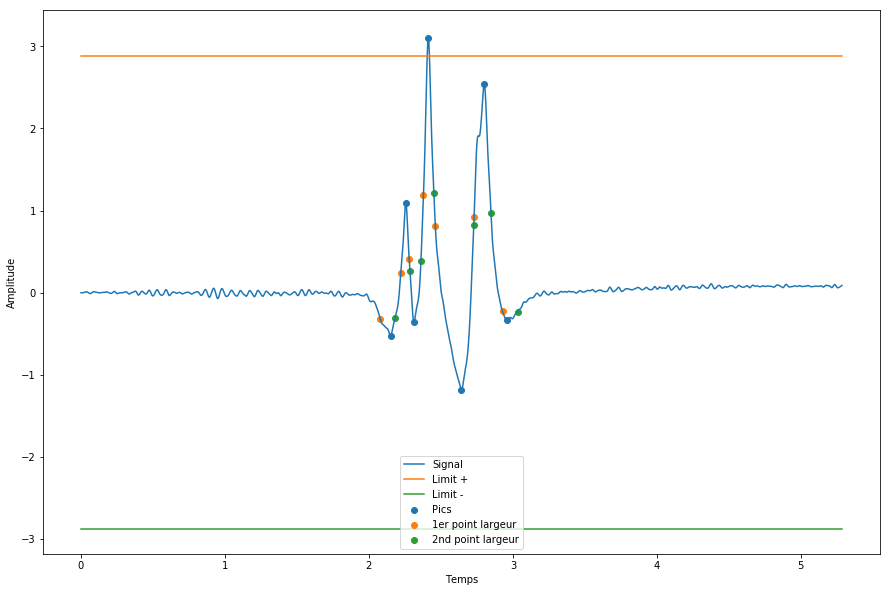

In [139]:
truck.show()